# Customer Segmentation : Clustering 

### Importing Libraries

In [110]:
# pip install yellowbrick

In [111]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [112]:
%matplotlib inline
sns.set_style(style='whitegrid')
sns.set_context(context ='notebook')
plt.rcParams['figure.figsize'] = (11, 9.4)

### Loading Data

In [113]:
data = pd.read_csv('../../data/interim/marketing_campaign.csv', sep='\t')
print('Number of datapoints ', len(data))
data.head()

Number of datapoints  2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### Data Cleaning
- Data cleaning
- Feature Engineering

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**From the above output, we can conclude and note that:**

- There are missing values in income
- Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime
- There are some categorical features in our data frame; as there are some features in dtype: object). So we will need to encode them into numeric forms later.

First of all, for the missing values, I am simply going to drop the rows that have missing income values.



In [115]:
data = data.dropna()
print('Number of datapoints after removing missing values ', len(data))

Number of datapoints after removing missing values  2216


In the next step, I am going to create a feature out of "Dt_Customer" that indicates the number of days a customer is registered in the firm's database. However, in order to keep it simple, I am taking this value relative to the most recent customer in the record.

Thus to get the values I must check the newest and oldest recorded dates.

In [116]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], dayfirst=True)
dates = []

for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

print(f"The newest customer's enrolment date in therecords:", max(dates))
print(f"The oldest customer's enrolment date in the records:", min(dates))


The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


Creating a feature ("Customer_For") of the number of days the customers started to shop in the store relative to the last recorded date

In [117]:
#created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta.days)
data['Customer_For'] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors='coerce')

Now we will be exploring the unique values in the categorical features to get a clear idea of the data.



In [118]:
print(f'Total categories in the feature Marital_status:\n {data["Marital_Status"].value_counts()}\n')

print(f'Total categories in the feature Education:\n {data["Education"].value_counts()}')

Total categories in the feature Marital_status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


**In the next bit, I will be performing the following steps to engineer some new features:**

- Extract the **"Age"** of a customer by the **"Year_Birth"** indicating the birth year of the respective person.
- Create another feature **"Spent"** indicating the total amount spent by the customer in various categories over the span of two years.
- Create another feature **"Living_With"** out of **"Marital_Status"** to extract the living situation of couples.
- Create a feature **"Children"** to indicate total children in a household that is, kids and teenagers.
- To get further clarity of household, Creating feature indicating **"Family_Size"**
- Create a feature **"Is_Parent"** to indicate parenthood status
- Lastly, I will create three categories in the **"Education"** by simplifying its value counts.
- Dropping some of the redundant features

In [119]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

Now that we have some new features let's have a look at the data's stats.



In [120]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,353.521209,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,202.434667,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,180.000000,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,355.500000,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,529.000000,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,699.000000,128.000000,2525.000000,3.000000,5.000000,1.000000


The above stats show some discrepancies in mean Income and Age and max Income and age.

Do note that max-age is 128 years, As I calculated the age that would be today (i.e. 2021) and the data is old.

I must take a look at the broader view of the data. I will plot some of the selected features.

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   Wines                2216 non-null   int64  
 6   Fruits               2216 non-null   int64  
 7   Meat                 2216 non-null   int64  
 8   Fish                 2216 non-null   int64  
 9   Sweets               2216 non-null   int64  
 10  Gold                 2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   int64 

Relative Plot Of s ome Selected Features: Adata Subset


<Figure size 1100x940 with 0 Axes>

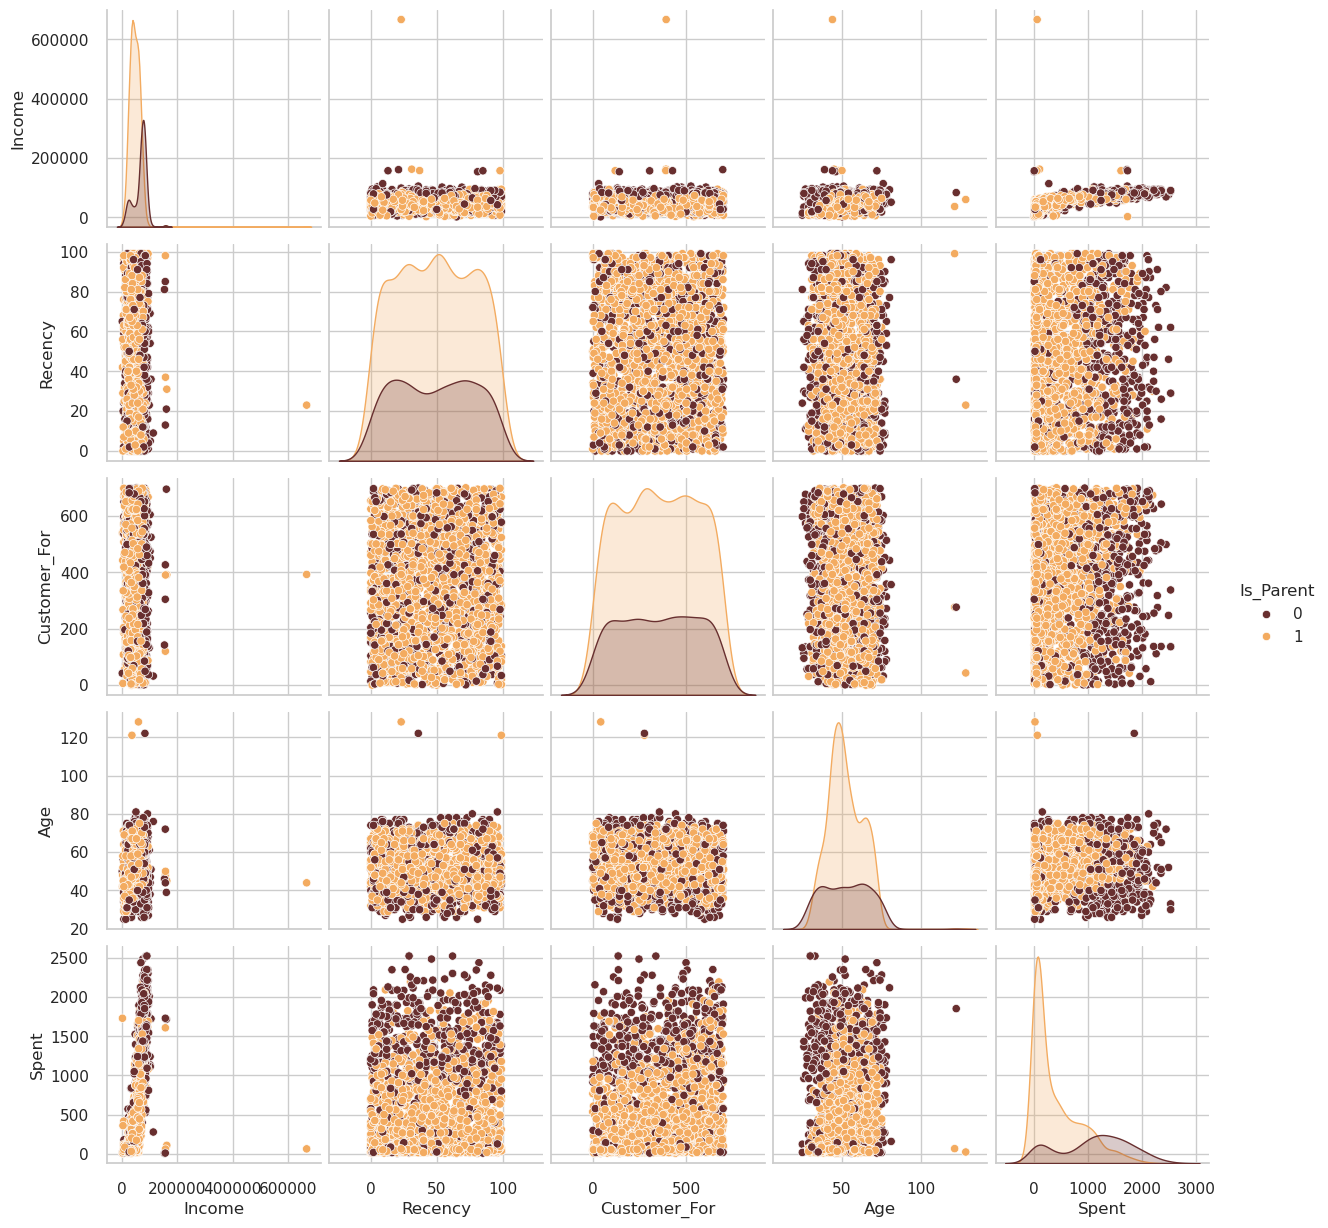

In [122]:
#To plot some selected features 
#Setting up colors preferences 
#sns.set_color_codes(rc={"axes.facecolr":"#FFF9ED", "figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Plotting following features
To_plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]

print("Relative Plot Of s ome Selected Features: Adata Subset")
plt.figure()

sns.pairplot(data[To_plot], hue = "Is_Parent", palette=(["#682F2F","#F3AB60"]))

plt.show()

Clearly, there are a few outliers in the Income and Age features. I will be deleting the outliers in the data.



In [123]:
#Dropping the outliers by setting a cap on Age and Income
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


Next, let us look at the correlation amongst the features. (Excluding the categorical attributes at this point)



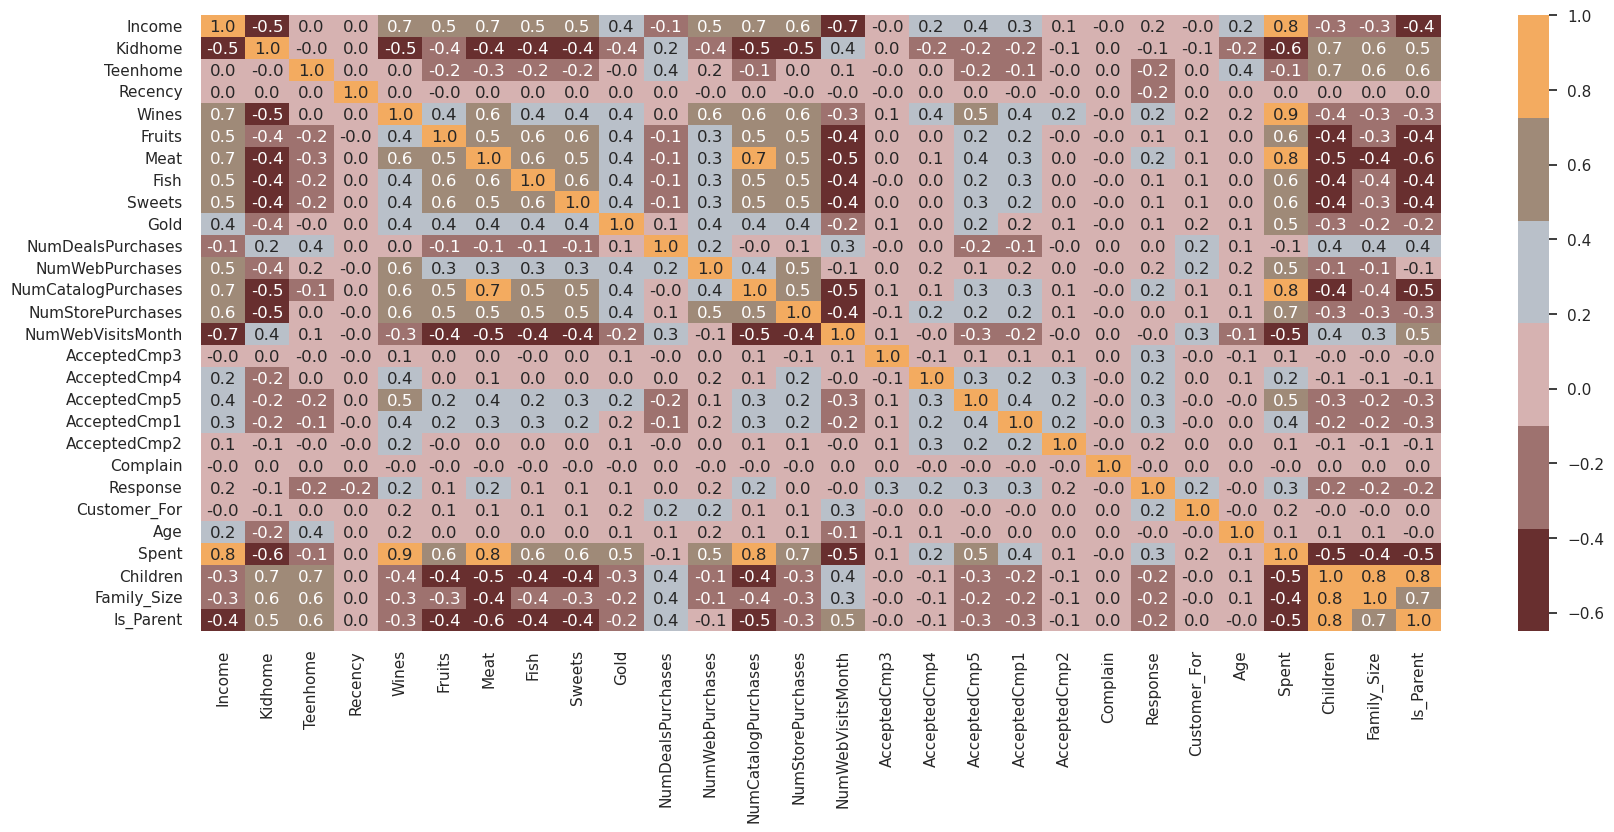

In [128]:
#correlation matrix
plt.figure(figsize=(20, 8))
corrmat = data.select_dtypes(include=np.number).corr()
sns.heatmap(corrmat, annot=True, cmap=cmap, fmt=".1f")
plt.show()

The data is quite clean and the new features have been included. I will proceed to the next step. That is, preprocessing the data

### Data Preprocessing

In this section, I will be preprocessing the data to perform clustering operations.

**The following steps are applied to preprocess the data:**

- Label encoding the categorical features
- Scaling the features using the standard scaler
- Creating a subset dataframe for dimensionality reduction


In [130]:
categorical = data.select_dtypes(include=[np.object]).columns
categorical

Index(['Education', 'Living_With'], dtype='object')

In [134]:
#Label Encoding the object type features
le = LabelEncoder()

data[categorical] = data[categorical].apply(le.fit_transform)


In [132]:
#Creating a copy of data
ds = data.copy()
# Creating a subset of dataframe by dropping the features on deals accepted a nd promotions

cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']

ds = ds.drop(cols_del, axis=1)
scaler = StandardScaler()
scaled_ds = pd.DataFrame(scaler.fit_transform(ds), columns=ds.columns)
